# 앙상블 모델
- LinearRegression 은 성능이 너무 안좋아서 제외함.

In [428]:
# !pip install eli5==0.13.0

# # 한글 폰트 사용을 위한 라이브러리입니다.
# !apt-get install -y fonts-nanum

In [429]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [430]:
# 앙상블시 모델별 가중치를 사용할지
IS_USE_WEIGHT = False

# 사용하려는 모델
IS_USE_RandomForest = False
IS_USE_GradientBoosting = False
IS_USE_LightGBM = False
IS_USE_XGBoost = True
IS_USE_LinearRegression = False

In [431]:
train_path = '../train_add_newXY.csv'
test_path  = '../test_add_newXY.csv'
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [432]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', df_train.shape, 'Test data shape : ', df_test.shape)

Train data shape :  (1118822, 54) Test data shape :  (9272, 53)


In [433]:
df_train.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', '좌표X_2', '좌표Y_2'],
      dtype='object')

### train, test 셋을 합쳐서 전처리 작업

In [434]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
df_train['is_test'] = 0
df_test['is_test'] = 1
df_concat = pd.concat([df_train, df_test])     # 하나의 데이터로 만들어줍니다.
df_concat.reset_index(drop=True, inplace=True)
df_concat

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,좌표X_2,좌표Y_2,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,127.056859,37.476276,0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,127.056859,37.476276,0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,127.056859,37.476276,0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,127.056859,37.476276,0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,117000.0,127.056859,37.476276,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.65,202307,19,13,2014,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,127.106467,37.617195,1
1128090,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.62,202307,25,12,2014,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,127.106467,37.617195,1
1128091,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,101.65,202308,27,12,2014,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,127.106467,37.617195,1
1128092,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.94,202309,2,18,2014,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,127.106467,37.617195,1


### 사용 안하는 컬럼 삭제

In [435]:
df_concat.drop(columns=['본번', '부번', '아파트명', '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 
                        'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
                        'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법',
                        '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일'], inplace=True)
df_concat.columns

Index(['시군구', '번지', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', 'target', '좌표X_2',
       '좌표Y_2', 'is_test'],
      dtype='object')

### 컬럼명 변경

In [436]:
df_concat.rename(columns={'전용면적(㎡)':'전용면적'}, inplace=True)
df_concat.columns

Index(['시군구', '번지', '전용면적', '계약년월', '계약일', '층', '건축년도', 'target', '좌표X_2',
       '좌표Y_2', 'is_test'],
      dtype='object')

### 최단거리 초등학교 정보 붙이기


In [437]:
df_elem_train = pd.read_csv('elemSchool_for_train.csv')
df_elem_test = pd.read_csv('elemSchool_for_test.csv')
df_elem_concat = pd.concat([df_elem_train, df_elem_test])
df_elem_concat.reset_index(drop=True, inplace=True)
df_elem_concat

,최단거리초등학교명,최단거리초등학교Km
0,서울포이초등학교,0.385832
1,서울포이초등학교,0.385832
2,서울포이초등학교,0.385832
3,서울포이초등학교,0.385832
4,서울포이초등학교,0.385832
...,...,...
1128089,서울새솔초등학교,0.437157
1128090,서울새솔초등학교,0.437157
1128091,서울새솔초등학교,0.437157
1128092,서울새솔초등학교,0.437157


In [438]:
df_concat = pd.concat([df_concat, df_elem_concat], axis=1)
df_concat

,시군구,번지,전용면적,계약년월,계약일,층,건축년도,target,좌표X_2,좌표Y_2,is_test,최단거리초등학교명,최단거리초등학교Km
0,서울특별시 강남구 개포동,658-1,79.97,201712,8,3,1987,124000.0,127.056859,37.476276,0,서울포이초등학교,0.385832
1,서울특별시 강남구 개포동,658-1,79.97,201712,22,4,1987,123500.0,127.056859,37.476276,0,서울포이초등학교,0.385832
2,서울특별시 강남구 개포동,658-1,54.98,201712,28,5,1987,91500.0,127.056859,37.476276,0,서울포이초등학교,0.385832
3,서울특별시 강남구 개포동,658-1,79.97,201801,3,4,1987,130000.0,127.056859,37.476276,0,서울포이초등학교,0.385832
4,서울특별시 강남구 개포동,658-1,79.97,201801,8,2,1987,117000.0,127.056859,37.476276,0,서울포이초등학교,0.385832
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,816,84.65,202307,19,13,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157
1128090,서울특별시 중랑구 신내동,816,84.62,202307,25,12,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157
1128091,서울특별시 중랑구 신내동,816,101.65,202308,27,12,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157
1128092,서울특별시 중랑구 신내동,816,84.94,202309,2,18,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,0.437157


### 지하철 정보 붙이기

In [439]:
train_subway_df = pd.read_csv('../train_with_subway_infos.csv')
test_subway_df = pd.read_csv('../test_with_subway_infos.csv')

total_subway_df = pd.concat([train_subway_df, test_subway_df], axis=0)
total_subway_df.reset_index(drop=True, inplace=True)
total_subway_df.drop(columns=['좌표X_2', '좌표Y_2'], inplace=True)

total_subway_df

,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,1번째_가까운_역_도보시간,2번째_가까운_역_이름,2번째_가까운_역_호선,2번째_가까운_역_거리,2번째_가까운_역_도보시간,3번째_가까운_역_이름,3번째_가까운_역_호선,3번째_가까운_역_거리,3번째_가까운_역_도보시간,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수
0,구룡,분당선,1187.672025,17.815080,매봉,3호선,1483.438090,22.251571,도곡,3호선,1633.265245,24.498979,0,0,0,1
1,구룡,분당선,1187.672025,17.815080,매봉,3호선,1483.438090,22.251571,도곡,3호선,1633.265245,24.498979,0,0,0,1
2,구룡,분당선,1187.672025,17.815080,매봉,3호선,1483.438090,22.251571,도곡,3호선,1633.265245,24.498979,0,0,0,1
3,구룡,분당선,1187.672025,17.815080,매봉,3호선,1483.438090,22.251571,도곡,3호선,1633.265245,24.498979,0,0,0,1
4,구룡,분당선,1187.672025,17.815080,매봉,3호선,1483.438090,22.251571,도곡,3호선,1633.265245,24.498979,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,신내,경춘선,558.051187,8.370768,신내,6호선,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2
1128090,신내,경춘선,558.051187,8.370768,신내,6호선,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2
1128091,신내,경춘선,558.051187,8.370768,신내,6호선,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2
1128092,신내,경춘선,558.051187,8.370768,신내,6호선,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2


In [440]:
df_concat = pd.concat([df_concat, total_subway_df], axis=1)
df_concat

,시군구,번지,전용면적,계약년월,계약일,층,건축년도,target,좌표X_2,좌표Y_2,...,2번째_가까운_역_거리,2번째_가까운_역_도보시간,3번째_가까운_역_이름,3번째_가까운_역_호선,3번째_가까운_역_거리,3번째_가까운_역_도보시간,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수
0,서울특별시 강남구 개포동,658-1,79.97,201712,8,3,1987,124000.0,127.056859,37.476276,...,1483.438090,22.251571,도곡,3호선,1633.265245,24.498979,0,0,0,1
1,서울특별시 강남구 개포동,658-1,79.97,201712,22,4,1987,123500.0,127.056859,37.476276,...,1483.438090,22.251571,도곡,3호선,1633.265245,24.498979,0,0,0,1
2,서울특별시 강남구 개포동,658-1,54.98,201712,28,5,1987,91500.0,127.056859,37.476276,...,1483.438090,22.251571,도곡,3호선,1633.265245,24.498979,0,0,0,1
3,서울특별시 강남구 개포동,658-1,79.97,201801,3,4,1987,130000.0,127.056859,37.476276,...,1483.438090,22.251571,도곡,3호선,1633.265245,24.498979,0,0,0,1
4,서울특별시 강남구 개포동,658-1,79.97,201801,8,2,1987,117000.0,127.056859,37.476276,...,1483.438090,22.251571,도곡,3호선,1633.265245,24.498979,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,816,84.65,202307,19,13,2014,NaN,127.106467,37.617195,...,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2
1128090,서울특별시 중랑구 신내동,816,84.62,202307,25,12,2014,NaN,127.106467,37.617195,...,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2
1128091,서울특별시 중랑구 신내동,816,101.65,202308,27,12,2014,NaN,127.106467,37.617195,...,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2
1128092,서울특별시 중랑구 신내동,816,84.94,202309,2,18,2014,NaN,127.106467,37.617195,...,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2


### 기준금리 붙이기

In [441]:
df_trainset_0718_3 = pd.read_csv('../trainset_0718_3.csv')

dfInterest = df_trainset_0718_3[['계약년월', '기준금리']]
dfInterest.drop_duplicates(inplace=True)
dfInterest.reset_index(drop=True, inplace=True)

del df_trainset_0718_3
dfInterest

,계약년월,기준금리
0,200701,4.5
1,200702,4.5
2,200703,4.5
3,200704,4.5
4,200705,4.5
...,...,...
196,202305,3.5
197,202306,3.5
198,202307,3.5
199,202308,3.5


In [442]:
df_concat = pd.merge(df_concat, dfInterest, on='계약년월', how='left')
df_concat

,시군구,번지,전용면적,계약년월,계약일,층,건축년도,target,좌표X_2,좌표Y_2,...,2번째_가까운_역_도보시간,3번째_가까운_역_이름,3번째_가까운_역_호선,3번째_가까운_역_거리,3번째_가까운_역_도보시간,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수,기준금리
0,서울특별시 강남구 개포동,658-1,79.97,201712,8,3,1987,124000.0,127.056859,37.476276,...,22.251571,도곡,3호선,1633.265245,24.498979,0,0,0,1,1.5
1,서울특별시 강남구 개포동,658-1,79.97,201712,22,4,1987,123500.0,127.056859,37.476276,...,22.251571,도곡,3호선,1633.265245,24.498979,0,0,0,1,1.5
2,서울특별시 강남구 개포동,658-1,54.98,201712,28,5,1987,91500.0,127.056859,37.476276,...,22.251571,도곡,3호선,1633.265245,24.498979,0,0,0,1,1.5
3,서울특별시 강남구 개포동,658-1,79.97,201801,3,4,1987,130000.0,127.056859,37.476276,...,22.251571,도곡,3호선,1633.265245,24.498979,0,0,0,1,1.5
4,서울특별시 강남구 개포동,658-1,79.97,201801,8,2,1987,117000.0,127.056859,37.476276,...,22.251571,도곡,3호선,1633.265245,24.498979,0,0,0,1,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,816,84.65,202307,19,13,2014,NaN,127.106467,37.617195,...,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2,3.5
1128090,서울특별시 중랑구 신내동,816,84.62,202307,25,12,2014,NaN,127.106467,37.617195,...,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2,3.5
1128091,서울특별시 중랑구 신내동,816,101.65,202308,27,12,2014,NaN,127.106467,37.617195,...,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2,3.5
1128092,서울특별시 중랑구 신내동,816,84.94,202309,2,18,2014,NaN,127.106467,37.617195,...,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2,3.5


### 시군구, 계약 년월 분리

In [443]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
df_concat['구'] = df_concat['시군구'].map(lambda x : x.split()[1])
df_concat['동'] = df_concat['시군구'].map(lambda x : x.split()[2])
del df_concat['시군구']

df_concat['계약년'] = df_concat['계약년월'].astype('str').map(lambda x : x[:4])
df_concat['계약월'] = df_concat['계약년월'].astype('str').map(lambda x : x[4:])
df_concat['계약년'] = df_concat['계약년'].astype('int16')
df_concat['계약월'] = df_concat['계약월'].astype('int16')
del df_concat['계약년월']

df_concat

,번지,전용면적,계약일,층,건축년도,target,좌표X_2,좌표Y_2,is_test,최단거리초등학교명,...,3번째_가까운_역_도보시간,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수,기준금리,구,동,계약년,계약월
0,658-1,79.97,8,3,1987,124000.0,127.056859,37.476276,0,서울포이초등학교,...,24.498979,0,0,0,1,1.5,강남구,개포동,2017,12
1,658-1,79.97,22,4,1987,123500.0,127.056859,37.476276,0,서울포이초등학교,...,24.498979,0,0,0,1,1.5,강남구,개포동,2017,12
2,658-1,54.98,28,5,1987,91500.0,127.056859,37.476276,0,서울포이초등학교,...,24.498979,0,0,0,1,1.5,강남구,개포동,2017,12
3,658-1,79.97,3,4,1987,130000.0,127.056859,37.476276,0,서울포이초등학교,...,24.498979,0,0,0,1,1.5,강남구,개포동,2018,1
4,658-1,79.97,8,2,1987,117000.0,127.056859,37.476276,0,서울포이초등학교,...,24.498979,0,0,0,1,1.5,강남구,개포동,2018,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,84.65,19,13,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,...,17.780895,0,2,0,2,3.5,중랑구,신내동,2023,7
1128090,816,84.62,25,12,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,...,17.780895,0,2,0,2,3.5,중랑구,신내동,2023,7
1128091,816,101.65,27,12,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,...,17.780895,0,2,0,2,3.5,중랑구,신내동,2023,8
1128092,816,84.94,2,18,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,...,17.780895,0,2,0,2,3.5,중랑구,신내동,2023,9


### KB부동산 매수우위지수 붙이기

In [444]:
df_KbJisu = pd.read_csv('../매수우위지수.csv')
df_KbJisu.drop(columns=['Unnamed: 0', '지역'], inplace=True)
df_KbJisu.rename(columns={'기준년도':'계약년', '기준월':'계약월'}, inplace=True)
df_KbJisu

,계약년,계약월,KB매수우위지수
0,2000,1,46.3
1,2000,2,44.8
2,2000,3,36.6
3,2000,4,30.6
4,2000,5,34.4
...,...,...,...
289,2024,2,25.6
290,2024,3,29.7
291,2024,4,33.0
292,2024,5,32.1


In [445]:
df_concat = pd.merge(df_concat, df_KbJisu, on=['계약년', '계약월'], how='left')
df_concat

,번지,전용면적,계약일,층,건축년도,target,좌표X_2,좌표Y_2,is_test,최단거리초등학교명,...,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수,기준금리,구,동,계약년,계약월,KB매수우위지수
0,658-1,79.97,8,3,1987,124000.0,127.056859,37.476276,0,서울포이초등학교,...,0,0,0,1,1.5,강남구,개포동,2017,12,88.4
1,658-1,79.97,22,4,1987,123500.0,127.056859,37.476276,0,서울포이초등학교,...,0,0,0,1,1.5,강남구,개포동,2017,12,88.4
2,658-1,54.98,28,5,1987,91500.0,127.056859,37.476276,0,서울포이초등학교,...,0,0,0,1,1.5,강남구,개포동,2017,12,88.4
3,658-1,79.97,3,4,1987,130000.0,127.056859,37.476276,0,서울포이초등학교,...,0,0,0,1,1.5,강남구,개포동,2018,1,118.0
4,658-1,79.97,8,2,1987,117000.0,127.056859,37.476276,0,서울포이초등학교,...,0,0,0,1,1.5,강남구,개포동,2018,1,118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,84.65,19,13,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,...,0,2,0,2,3.5,중랑구,신내동,2023,7,38.0
1128090,816,84.62,25,12,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,...,0,2,0,2,3.5,중랑구,신내동,2023,7,38.0
1128091,816,101.65,27,12,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,...,0,2,0,2,3.5,중랑구,신내동,2023,8,46.0
1128092,816,84.94,2,18,2014,NaN,127.106467,37.617195,1,서울새솔초등학교,...,0,2,0,2,3.5,중랑구,신내동,2023,9,41.4


### 결측치 확인

In [446]:
df_concat.isnull().sum()

번지                     0
전용면적                   0
계약일                    0
층                      0
건축년도                   0
target              9272
좌표X_2                  0
좌표Y_2                  0
is_test                0
최단거리초등학교명              0
최단거리초등학교Km             0
1번째_가까운_역_이름           0
1번째_가까운_역_호선           0
1번째_가까운_역_거리           0
1번째_가까운_역_도보시간         0
2번째_가까운_역_이름           0
2번째_가까운_역_호선           0
2번째_가까운_역_거리           0
2번째_가까운_역_도보시간         0
3번째_가까운_역_이름           0
3번째_가까운_역_호선           0
3번째_가까운_역_거리           0
3번째_가까운_역_도보시간         0
5분이하_역_개수              0
5분초과_10분이하_역_개수        0
10분초과_15분이하_역_개수       0
15분초과_20분이하_역_개수       0
기준금리                   0
구                      0
동                      0
계약년                    0
계약월                    0
KB매수우위지수               0
dtype: int64

### 범주형 변수의 인코딩

In [447]:
continuous_columns = []
categorical_columns = []

for column in df_concat.columns:
    if pd.api.types.is_numeric_dtype(df_concat[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'target', '좌표X_2', '좌표Y_2', 'is_test', '최단거리초등학교Km', '1번째_가까운_역_거리', '1번째_가까운_역_도보시간', '2번째_가까운_역_거리', '2번째_가까운_역_도보시간', '3번째_가까운_역_거리', '3번째_가까운_역_도보시간', '5분이하_역_개수', '5분초과_10분이하_역_개수', '10분초과_15분이하_역_개수', '15분초과_20분이하_역_개수', '기준금리', '계약년', '계약월', 'KB매수우위지수']
범주형 변수: ['번지', '최단거리초등학교명', '1번째_가까운_역_이름', '1번째_가까운_역_호선', '2번째_가까운_역_이름', '2번째_가까운_역_호선', '3번째_가까운_역_이름', '3번째_가까운_역_호선', '구', '동']


In [448]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=categorical_columns)
df_concat = encoder.fit_transform(df_concat)
df_concat

,번지_0,번지_1,번지_2,번지_3,번지_4,번지_5,번지_6,번지_7,번지_8,번지_9,...,동_2,동_3,동_4,동_5,동_6,동_7,동_8,계약년,계약월,KB매수우위지수
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2017,12,88.4
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2017,12,88.4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2017,12,88.4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2018,1,118.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2018,1,118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,2023,7,38.0
1128090,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,2023,7,38.0
1128091,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,2023,8,46.0
1128092,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,2023,9,41.4


In [449]:
df_concat.columns

Index(['번지_0', '번지_1', '번지_2', '번지_3', '번지_4', '번지_5', '번지_6', '번지_7', '번지_8',
       '번지_9',
       ...
       '동_2', '동_3', '동_4', '동_5', '동_6', '동_7', '동_8', '계약년', '계약월',
       'KB매수우위지수'],
      dtype='object', length=102)

### 다시 train 셋, test 셋으로 분리

In [450]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
df_train = df_concat.query('is_test==0')
df_test = df_concat.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
df_train.drop(['is_test'], axis = 1, inplace=True)
df_test.drop(['is_test'], axis = 1, inplace=True)

df_test.reset_index(drop=True, inplace=True)

display(df_train)
display(df_test)

,번지_0,번지_1,번지_2,번지_3,번지_4,번지_5,번지_6,번지_7,번지_8,번지_9,...,동_2,동_3,동_4,동_5,동_6,동_7,동_8,계약년,계약월,KB매수우위지수
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2017,12,88.4
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2017,12,88.4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2017,12,88.4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2018,1,118.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2018,1,118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,0,1,0,1,0,1,0,0,1,0,...,1,1,1,1,0,1,1,2007,7,66.8
1118818,0,1,0,1,0,1,0,0,1,0,...,1,1,1,1,0,1,1,2007,8,68.6
1118819,0,1,0,1,0,1,0,0,1,0,...,1,1,1,1,0,1,1,2007,8,68.6
1118820,0,1,0,1,0,1,0,0,1,0,...,1,1,1,1,0,1,1,2007,9,67.1


,번지_0,번지_1,번지_2,번지_3,번지_4,번지_5,번지_6,번지_7,번지_8,번지_9,...,동_2,동_3,동_4,동_5,동_6,동_7,동_8,계약년,계약월,KB매수우위지수
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2023,7,38.0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,2023,8,46.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2023,7,38.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2023,8,46.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2023,8,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,2023,7,38.0
9268,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,2023,7,38.0
9269,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,2023,8,46.0
9270,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,2023,9,41.4


### train 데이터셋에서 target 컬럼을 별도의 데이터프레임으로 빼기, test 데이터셋에서 target 컬럼 제거.

In [451]:
df_train_target = pd.DataFrame(df_train['target'])
display(df_train_target)

df_train.drop(columns=['target'], inplace=True)
df_test.drop(columns=['target'], inplace=True)

display(df_train)
display(df_test)

,target
0,124000.0
1,123500.0
2,91500.0
3,130000.0
4,117000.0
...,...
1118817,20000.0
1118818,20000.0
1118819,28000.0
1118820,29000.0


,번지_0,번지_1,번지_2,번지_3,번지_4,번지_5,번지_6,번지_7,번지_8,번지_9,...,동_2,동_3,동_4,동_5,동_6,동_7,동_8,계약년,계약월,KB매수우위지수
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2017,12,88.4
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2017,12,88.4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2017,12,88.4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2018,1,118.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2018,1,118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,0,1,0,1,0,1,0,0,1,0,...,1,1,1,1,0,1,1,2007,7,66.8
1118818,0,1,0,1,0,1,0,0,1,0,...,1,1,1,1,0,1,1,2007,8,68.6
1118819,0,1,0,1,0,1,0,0,1,0,...,1,1,1,1,0,1,1,2007,8,68.6
1118820,0,1,0,1,0,1,0,0,1,0,...,1,1,1,1,0,1,1,2007,9,67.1


,번지_0,번지_1,번지_2,번지_3,번지_4,번지_5,번지_6,번지_7,번지_8,번지_9,...,동_2,동_3,동_4,동_5,동_6,동_7,동_8,계약년,계약월,KB매수우위지수
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2023,7,38.0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,2023,8,46.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2023,7,38.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2023,8,46.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2023,8,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,2023,7,38.0
9268,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,2023,7,38.0
9269,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,2023,8,46.0
9270,0,1,0,0,1,0,0,0,0,1,...,0,1,1,1,0,1,1,2023,9,41.4


### 모델 학습

In [452]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [453]:
# 데이터 준비 (X는 특성, y는 타겟 변수)
X_train, X_valid, y_train, y_valid = train_test_split(df_train, df_train_target, test_size=0.2, random_state=42)

In [454]:
display(X_train.shape)
display(df_test.shape)

(895057, 100)

(9272, 100)

In [455]:
# 개별 모델 정의
# LinearRegression 은 성능이 너무 낮아서 제외함
models = {}

if IS_USE_RandomForest:     models['RandomForest'] = RandomForestRegressor(n_estimators=100, random_state=42)
if IS_USE_GradientBoosting: models['GradientBoosting'] = GradientBoostingRegressor(n_estimators=100, random_state=42)
if IS_USE_LightGBM:         models['LightGBM'] = lgb.LGBMRegressor(n_estimators=100, random_state=42)
if IS_USE_XGBoost:          models['XGBoost'] = xgb.XGBRegressor(n_estimators=100, random_state=42)
if IS_USE_LinearRegression: models['LinearRegression'] = LinearRegression()

In [456]:
# 각 모델 학습 및 예측
pred_train = {}
pred_valid = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred_train[name] = model.predict(X_train)
    pred_valid[name] = model.predict(X_valid)

if 'LinearRegression' in pred_train: pred_train['LinearRegression'] = pred_train['LinearRegression'].flatten()
if 'LinearRegression' in pred_valid: pred_valid['LinearRegression'] = pred_valid['LinearRegression'].flatten()

In [457]:
if 'RandomForest' in models:
    importances = pd.Series(models['RandomForest'].feature_importances_, index=list(X_train.columns))
    importances = importances.sort_values(ascending=False)

    plt.figure(figsize=(10,15))
    plt.title("Feature Importances")
    sns.barplot(x=importances, y=importances.index)
    plt.show()

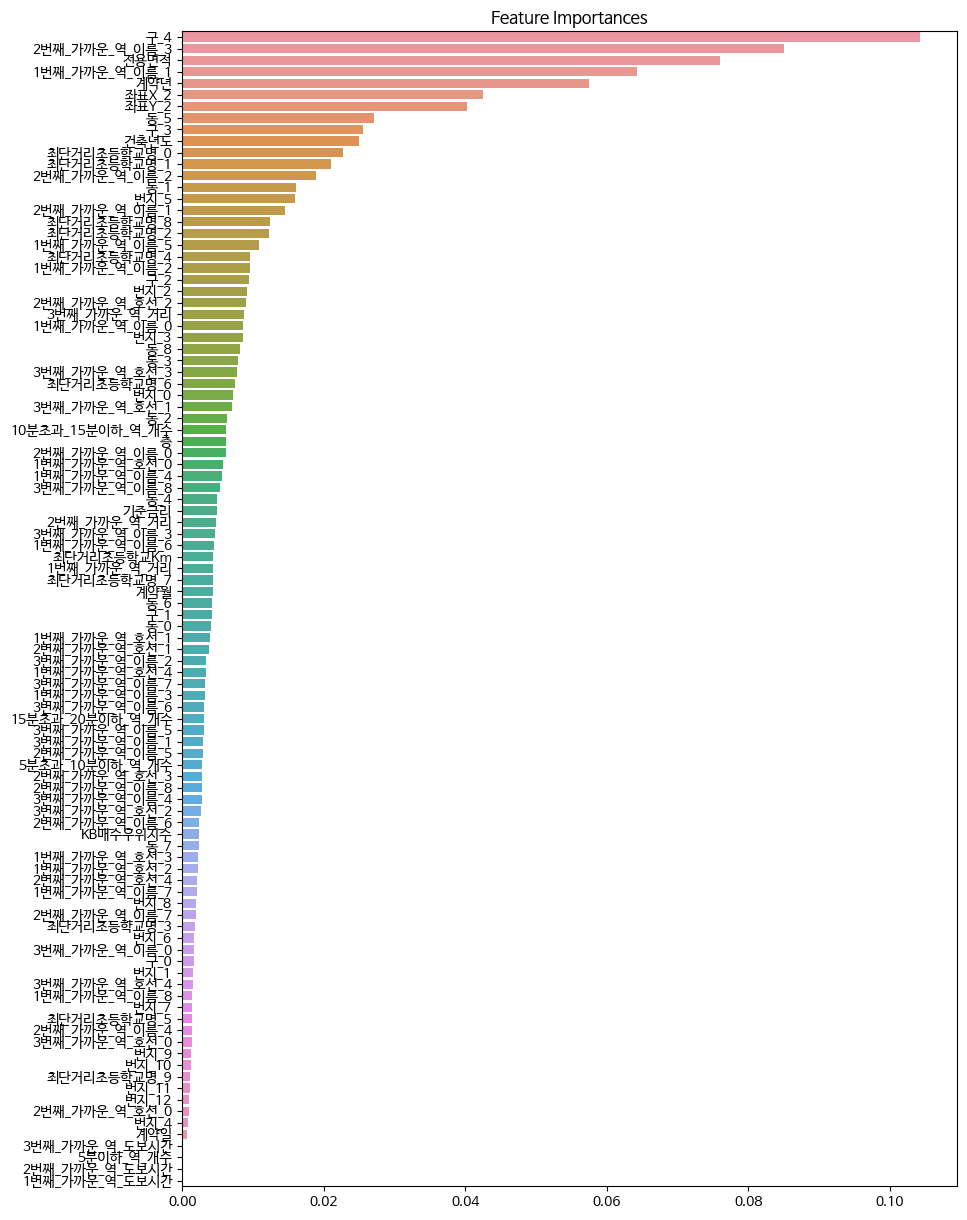

In [458]:
if 'XGBoost' in models:
    importances = pd.Series(models['XGBoost'].feature_importances_, index=list(X_train.columns))
    importances = importances.sort_values(ascending=False)

    plt.figure(figsize=(10,15))
    plt.title("Feature Importances")
    sns.barplot(x=importances, y=importances.index)
    plt.show()

In [459]:
# 가중치 기반 앙상블 (선택사항)
# 각 모델의 성능에 따라 가중치를 조정할 수 있습니다
weights = {
    'RandomForest': 0.9,
    'GradientBoosting': 0.025,
    'LightGBM': 0.025,
    'XGBoost': 0.025,
    'LinearRegression': 0.025
}

In [460]:
# 앙상블 (평균) 예측
if IS_USE_WEIGHT:
    ensemble_pred_train = np.mean([weights[name] * pred for name, pred in pred_train.items()], axis=0)
    ensemble_pred_valid = np.mean([weights[name] * pred for name, pred in pred_valid.items()], axis=0)
else:
    ensemble_pred_train = np.mean([pred for pred in pred_train.values()], axis=0)
    ensemble_pred_valid = np.mean([pred for pred in pred_valid.values()], axis=0)

In [461]:
# 개별 모델 성능 평가
for name, pred in pred_train.items():
    mse = mean_squared_error(y_train, pred)
    mae = mean_absolute_error(y_train, pred)
    r2 = r2_score(y_train, pred)
    print(f"[Train] {name} - RMSE: {np.sqrt(mse):.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

for name, pred in pred_valid.items():
    mse = mean_squared_error(y_valid, pred)
    mae = mean_absolute_error(y_valid, pred)
    r2 = r2_score(y_valid, pred)
    print(f"[Valid] {name} - RMSE: {np.sqrt(mse):.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

[Train] XGBoost - RMSE: 9269.2093, MAE: 5616.3373, R2: 0.9600
[Valid] XGBoost - RMSE: 9758.9132, MAE: 5685.6165, R2: 0.9562


In [462]:
# 앙상블 모델 성능 평가
ensemble_mse_train = mean_squared_error(y_train, ensemble_pred_train)
ensemble_mae_train = mean_absolute_error(y_train, ensemble_pred_train)
ensemble_r2_train = r2_score(y_train, ensemble_pred_train)
print(f"[Train] Ensemble - RMSE: {np.sqrt(ensemble_mse_train):.4f}, R2: {ensemble_r2_train:.4f}, MAE: {ensemble_mae_train:.4f}")

ensemble_mse_valid = mean_squared_error(y_valid, ensemble_pred_valid)
ensemble_mae_valid = mean_absolute_error(y_valid, ensemble_pred_valid)
ensemble_r2_valid = r2_score(y_valid, ensemble_pred_valid)
print(f"[Valid] Ensemble - RMSE: {np.sqrt(ensemble_mse_valid):.4f}, R2: {ensemble_r2_valid:.4f}, MAE: {ensemble_mae_valid:.4f}")

[Train] Ensemble - RMSE: 9269.2093, R2: 0.9600, MAE: 5616.3373
[Valid] Ensemble - RMSE: 9758.9132, R2: 0.9562, MAE: 5685.6165


In [463]:
def evaluate_model_fit(train_rmse, val_rmse, threshold=0.1):
    """
    모델의 성능을 평가하고 오버피팅/언더피팅 여부를 판단합니다.
    
    :param train_rmse: 훈련 데이터의 RMSE
    :param val_rmse: 검증 데이터의 RMSE
    :param threshold: 오버피팅/언더피팅을 판단하는 임계값 (기본값: 0.1)
    :return: 평가 결과 문자열, 상태
    """
    relative_diff = (val_rmse - train_rmse) / train_rmse

    if relative_diff > threshold:
        return f"오버피팅 징후가 있습니다. (차이: {relative_diff:.4f})", "오버피팅"
    elif relative_diff < -threshold:
        return f"언더피팅 징후가 있습니다. (차이: {relative_diff:.4f})", "언더피팅"
    else:
        return f"모델이 적절하게 피팅되었습니다. (차이: {relative_diff:.4f})", "적절"

# 모델 평가
evaluation_result, fit_status = evaluate_model_fit(np.sqrt(ensemble_mse_train), np.sqrt(ensemble_mse_valid), threshold=0.17)
print(evaluation_result)

# 해석 결과 출력
print(f"\n실험 결과 해석:")
if fit_status == "오버피팅":
    print("이번 실험은 오버피팅 되었습니다.")
    print("제안: 모델의 복잡도를 줄이거나, 규제를 강화하거나, 더 많은 훈련 데이터를 사용해 보세요.")
elif fit_status == "언더피팅":
    print("이번 실험은 언더피팅 되었습니다.")
    print("제안: 모델의 복잡도를 높이거나, 더 많은 특성을 추가하거나, 특성 엔지니어링을 수행해 보세요.")
else:
    print("이번 실험은 적절하게 학습되었습니다.")
    print("제안: 현재 모델이 잘 작동하고 있습니다. 필요하다면 미세 조정을 통해 성능을 더 개선해 볼 수 있습니다.")

모델이 적절하게 피팅되었습니다. (차이: 0.0528)

실험 결과 해석:
이번 실험은 적절하게 학습되었습니다.
제안: 현재 모델이 잘 작동하고 있습니다. 필요하다면 미세 조정을 통해 성능을 더 개선해 볼 수 있습니다.


In [464]:
# R-squared 및 MAE 해석
def evaluate_r2(r2):
    print("\nR-squared 및 MAE 해석:")
    if r2 < 0.5:
        print("R-squared 값이 낮습니다. 모델이 데이터의 변동성을 잘 설명하지 못하고 있습니다.")
    elif r2 >= 0.5 and r2 < 0.7:
        print("R-squared 값이 중간 정도입니다. 모델이 데이터의 변동성을 어느 정도 설명하고 있습니다.")
    else:
        print("R-squared 값이 높습니다. 모델이 데이터의 변동성을 잘 설명하고 있습니다.")

def evaluate_mae_rmse(mae, rmse):
    if mae > rmse:
        print("MAE가 RMSE보다 큽니다. 이는 이상치의 영향이 크지 않음을 시사합니다.")
    else:
        print("RMSE가 MAE보다 큽니다. 이는 일부 큰 오차가 존재할 수 있음을 시사합니다.")

    print(f"\nMAE/RMSE 비율: {mae/rmse:.4f}")
    if mae/rmse > 0.9:
        print("MAE와 RMSE가 비슷합니다. 오차가 일관되게 분포되어 있을 가능성이 높습니다.")
    elif mae/rmse < 0.7:
        print("RMSE가 MAE보다 상당히 큽니다. 일부 큰 오차가 모델의 성능에 큰 영향을 미치고 있을 수 있습니다.")
    else:
        print("MAE와 RMSE의 차이가 적당합니다. 오차 분포가 적절해 보입니다.")    

def evaluate_additional_info(val_rmse, train_rmse, val_mae, train_mae, val_r2, train_r2):
    # 추가적인 정보 제공
    print(f"\n추가 정보:")
    print(f"Train RMSE와 Validation RMSE의 절대적 차이: {abs(val_rmse - train_rmse):.4f}")
    print(f"Train RMSE 대비 Validation RMSE의 비율: {val_rmse / train_rmse:.4f}")
    print(f"R-squared 차이 (Train - Validation): {train_r2 - val_r2:.4f}")
    print(f"MAE 차이 (Validation - Train): {val_mae - train_mae:.4f}")

evaluate_r2(ensemble_r2_valid)
evaluate_mae_rmse(ensemble_mae_valid, np.sqrt(ensemble_mse_valid))
evaluate_additional_info(np.sqrt(ensemble_mse_valid), np.sqrt(ensemble_mse_train), 
                         ensemble_mae_valid, ensemble_mae_train, 
                         ensemble_r2_valid, ensemble_r2_train)


R-squared 및 MAE 해석:
R-squared 값이 높습니다. 모델이 데이터의 변동성을 잘 설명하고 있습니다.
RMSE가 MAE보다 큽니다. 이는 일부 큰 오차가 존재할 수 있음을 시사합니다.

MAE/RMSE 비율: 0.5826
RMSE가 MAE보다 상당히 큽니다. 일부 큰 오차가 모델의 성능에 큰 영향을 미치고 있을 수 있습니다.

추가 정보:
Train RMSE와 Validation RMSE의 절대적 차이: 489.7039
Train RMSE 대비 Validation RMSE의 비율: 1.0528
R-squared 차이 (Train - Validation): 0.0038
MAE 차이 (Validation - Train): 69.2791


### 추론

In [465]:
pred_test = {}
for name, model in models.items():
    pred_test[name] = model.predict(df_test)

if 'LinearRegression' in pred_test: pred_test['LinearRegression'] = pred_test['LinearRegression'].flatten()

if IS_USE_WEIGHT:
    ensemble_pred_test = np.mean([weights[name] * pred for name, pred in pred_test.items()], axis=0)
else:
    ensemble_pred_test = np.mean([pred for pred in pred_test.values()], axis=0)

### Output 파일 저장

In [466]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(ensemble_pred_test.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)